In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


In [4]:
BATCH_SIZE = 512
RNN_HIDDEN_SIZE = 128

In [5]:
def model_fn(features, labels, mode):
    # input_layer = tf.reshape(features["x"], [-1, 784, 1])

    # rnn_cell = tf.nn.rnn_cell.LSTMCell(RNN_HIDDEN_SIZE)
    # initial_state = rnn_cell.zero_state(batch_size=BATCH_SIZE, dtype=tf.float32)
    # _, state = tf.nn.dynamic_rnn(rnn_cell, input_layer, initial_state=initial_state, dtype=tf.float32)
    
    # dense1 = tf.layers.dense(inputs=tf.reshape(state, [-1, RNN_HIDDEN_SIZE * 2]), units=512, activation=tf.nn.relu)
    # dense2 = tf.layers.dense(inputs=dense1, units=1024, activation=tf.nn.relu)
    
    input_layer = tf.reshape(features['x'], [-1, 28, 28, 1])
    conv1 = tf.layers.conv2d(inputs=input_layer,
                             filters=32,
                             kernel_size=[5, 5],
                             padding="same",
                             activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(inputs=pool1,
                             filters=64,
                             kernel_size=[5, 5],
                             padding="same",
                             activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    
    predictions = tf.layers.dense(inputs=dense, units=784)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    loss = tf.losses.mean_squared_error(labels=labels, predictions=predictions)

    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    eval_metric_ops = {'distance': tf.metrics.mean_squared_error(labels=labels, predictions=predictions)}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [6]:
est = tf.estimator.Estimator(model_fn=model_fn, model_dir='pattern_memorization_model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'pattern_memorization_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001ECCB871FD0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
logging_hook = tf.train.LoggingTensorHook(tensors={}, at_end=True)

train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": train_data},
                                                    y=train_data,
                                                    batch_size=BATCH_SIZE,
                                                    num_epochs=None,
                                                    shuffle=True)
est.train(input_fn=train_input_fn, steps=2000, hooks=[logging_hook])

In [8]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": eval_data},
                                                   y=eval_data,
                                                   num_epochs=1,
                                                   shuffle=False)
est.evaluate(input_fn=eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-08-07:09:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from pattern_memorization_model\model.ckpt-2001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-08-07:10:00
INFO:tensorflow:Saving dict for global step 2001: distance = 0.0041406923, global_step = 2001, loss = 0.0041421107


{'distance': 0.0041406923, 'global_step': 2001, 'loss': 0.0041421107}

In [9]:
test_images = eval_data[np.random.choice(mnist.test.num_examples, 3)]
input_fn = tf.estimator.inputs.numpy_input_fn(x={'x': test_images}, shuffle=False)
preds = list(est.predict(input_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from pattern_memorization_model\model.ckpt-2001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


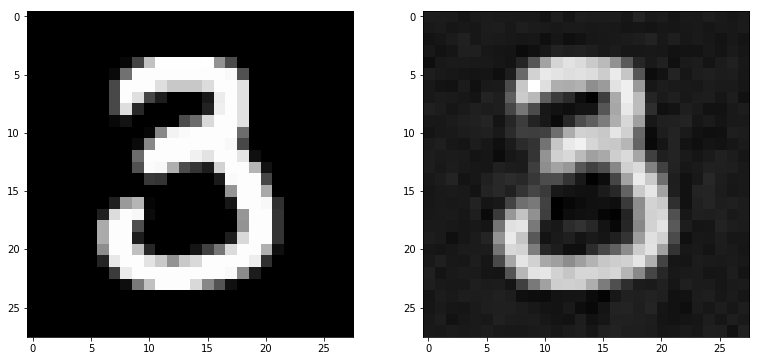

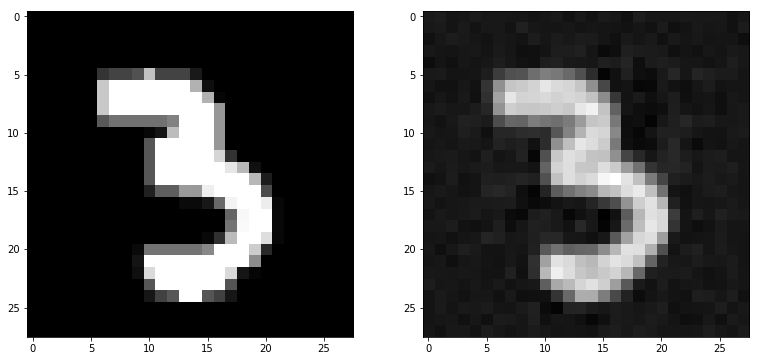

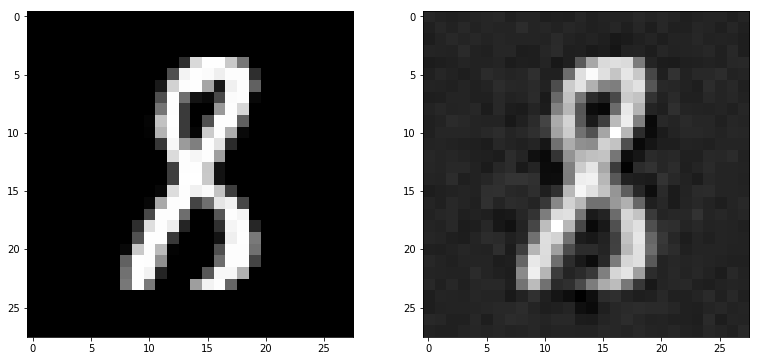

In [10]:
plt.rcParams["figure.figsize"] = [13, 6]

for i in range(3):
    plt.subplot(1, 2, 1)
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(np.reshape(preds[i], [28, 28]), cmap='gray')
    plt.show()

In [38]:
test_image = np.random.randn(1, 28, 28).astype(np.float32)
test_image[test_image < 0] = 0
test_image[test_image > 1] = 1.0
for i in range(10, 20):
    for j in range(28):
        test_image[0][i][j] = 1.0
test_image[0]

array([[0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 7.0362359e-01, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 7.3563862e-01, 4.9851304e-01,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 6.0358524e-01,
        0.0000000e+00, 1.0000000e+00, 4.6762288e-01, 1.1014733e-01,
        9.5784771e-01, 8.4708333e-01, 5.5154389e-01, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [4.2181920e-02, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        2.4159828e-01, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 2.2980547e-01,
        0.0000000e+00, 4.2563581e-01, 0.0000000e+00, 5.5309251e-02,
        4.6681657e-01, 8.7859279e-01, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 9.3483454e-01, 0.0000000e+00,
        0.0000000e+00, 4.5324823e-01, 1.0000000e+00, 6.3102686e-01],
       [0.0000000e+00, 7.8596987e-02, 0.000000

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from pattern_memorization_model\model.ckpt-2001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


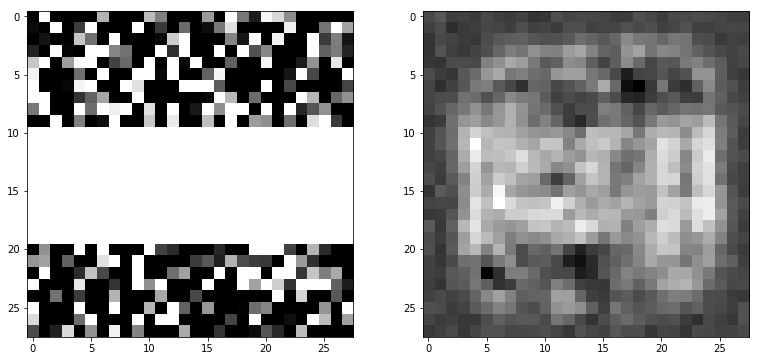

In [39]:
input_fn = tf.estimator.inputs.numpy_input_fn(x={'x': test_image}, shuffle=False)
pred = list(est.predict(input_fn))

plt.subplot(1, 2, 1)
plt.imshow(np.reshape(test_image, [28, 28]), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(np.reshape(pred[0], [28, 28]), cmap='gray')
plt.show()

In [40]:
est.evaluate(input_fn=tf.estimator.inputs.numpy_input_fn(x={"x": test_image},
                                                         y=test_image.reshape(1, 784),
                                                         num_epochs=1,
                                                         shuffle=False))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-08-08:04:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from pattern_memorization_model\model.ckpt-2001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-08-08:04:11
INFO:tensorflow:Saving dict for global step 2001: distance = 0.2170231, global_step = 2001, loss = 0.2170231


{'distance': 0.2170231, 'global_step': 2001, 'loss': 0.2170231}

In [47]:
test_image = np.random.randn(1, 28, 28).astype(np.float32)
test_image[test_image < 0] = 0
test_image[test_image > 0] = 0.25
for i in list(range(0, 4)) + list(range(24, 28)):
    for j in range(0, 28):
        test_image[0][i][j] = 1.0
        test_image[0][j][i] = 1.0
test_image[0]

array([[1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.25, 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  ,
        0.25, 0.  , 1.  , 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 1.  , 0. 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from pattern_memorization_model\model.ckpt-2001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


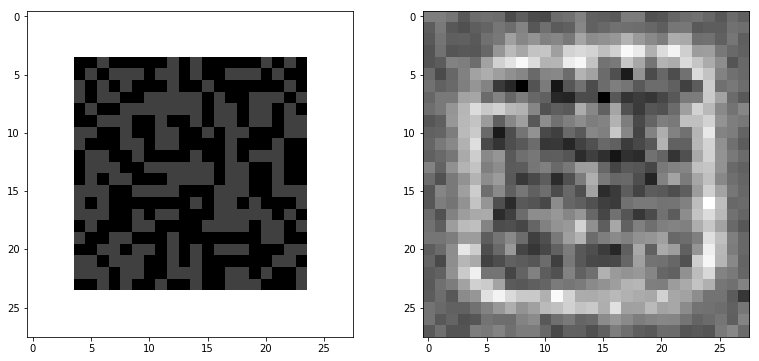

In [48]:
input_fn = tf.estimator.inputs.numpy_input_fn(x={'x': test_image}, shuffle=False)
pred = list(est.predict(input_fn))

plt.subplot(1, 2, 1)
plt.imshow(np.reshape(test_image, [28, 28]), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(np.reshape(pred[0], [28, 28]), cmap='gray')
plt.show()

# 끗